<a href="https://colab.research.google.com/github/alexanderruse1/ContainerGym/blob/main/APE_ContainerGym_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast-Augmented Actor-Critic (APE) in ContainerGym
This notebook combines the environment configuration, Kalman forecasting, agent definition, and training loop.

In [ ]:
import gym
import numpy as np
from gym import spaces
from dataclasses import dataclass, field
from typing import List, Dict

# Why use dataclasses for list structures?
# Allows modular, declarative definitions of complex structured inputs (like reward shapes)
# Supports programmatic configuration generation, validation, and reuse
# Enables nested configurations for clean and scalable environments

# Configuration Classes
# Defines the shape of the reward function as a mixture of Gaussian-like peaks.
@dataclass
class RewardParam:
    peaks: List[float]
    heights: List[float]
    widths: List[float]

# Defines per-container stochastic behavior and reward profile
@dataclass
class ContainerConfig:
    mu: float # Mean fill rate (controls stochastic dynamics)
    sigma: float  # Std dev of fill rate (controls noise in fill)
    max_volume: float  # Maximum allowable volume (capacity threshold)
    bale_size: float # Amount removed when emptied
    press_offset: float #not used in the code
    press_slope: float #not used in the code
    reward: RewardParam # Reward curve parameters

# Defines global environment settings and container collection
@dataclass
class EnvConfig:
    max_episode_length: int = 1500 # Total time steps in an episode
    timestep: int = 120 # Simulated seconds per step
    enabled_containers: List[str] = field(default_factory=list) # Containers to include
    n_presses: int = 2 # Number of containers we can empty per step
    min_starting_volume: float = 0 # Lower bound for initial fill
    max_starting_volume: float = 30 # Upper bound for initial fill
    failure_penalty: float = -1  # Penalty for overflow
    min_reward: float = -0.1 # Small penalty for waiting
    containers: Dict[str, ContainerConfig] = field(default_factory=dict)

# Container Environment
class ContainerEnv(gym.Env):
    def __init__(self, config: EnvConfig):
        super().__init__()
        self.config = config
        self.container_ids = config.enabled_containers
        self.n_containers = len(self.container_ids)
        self.n_presses = config.n_presses
        self.max_volume = max(cfg.max_volume for cfg in config.containers.values())
        self.episode_length = config.max_episode_length
        self.t = 0
# Randomize starting volume for each container
        self.volume = np.random.uniform(config.min_starting_volume,
                                        config.max_starting_volume,
                                        size=self.n_containers)
# Sample container-specific stochastic fill rates from a normal distribution
        self.fill_rates = np.array([
            np.random.normal(loc=config.containers[cid].mu,
                             scale=config.containers[cid].sigma)
            for cid in self.container_ids
        ])
# Discrete action space: one action per container + one "wait" action
        self.action_space = spaces.Discrete(self.n_containers + 1)
# Observation space: continuous vector of volumes (one per container)
        self.observation_space = spaces.Box(low=0, high=self.max_volume,
                                            shape=(self.n_containers,), dtype=np.float32)

    def reset(self):
# Resample starting volumes and stochastic fill rates
        self.volume = np.random.uniform(self.config.min_starting_volume,
                                        self.config.max_starting_volume,
                                        size=self.n_containers)
        self.fill_rates = np.array([
            np.random.normal(loc=self.config.containers[cid].mu,
                             scale=self.config.containers[cid].sigma)
            for cid in self.container_ids
        ])
        self.t = 0
        return {"volume": self.volume.copy()}

    def _reward_fn(self, cid: str, volume: float) -> float:
# Computes total reward from all reward peaks using a sum of Gaussians
        reward = 0
        params = self.config.containers[cid].reward
        for h, p, w in zip(params.heights, params.peaks, params.widths):
            reward += h * np.exp(-((volume - p) ** 2) / (2 * w ** 2))
        return reward

    def step(self, action):
        self.t += 1
        done = self.t >= self.episode_length
        reward = 0
# Update volumes using stochastic fill
        self.volume += self.fill_rates

        if action < self.n_containers:
# Empty selected container and collect reward based on current volume
            cid = self.container_ids[action]
            v = self.volume[action]
            reward = self._reward_fn(cid, v)
            self.volume[action] = 0
        else:
 # Apply mild penalty for taking no action
            reward = -0.01
 # If any container overflows, apply harsh penalty and end episode
        if np.any(self.volume > self.max_volume):
            reward = self.config.failure_penalty
            done = True

        return {"volume": self.volume.copy()}, reward, done, {}

    def render(self, mode='human'):
        print(f"Step {self.t}, Volumes: {self.volume}")

# Example Configuration
env_config = EnvConfig(
    enabled_containers=["C1-20", "C1-30", "C1-60", "C1-70", "C1-80"],
    containers={
        "C1-20": ContainerConfig(
            mu=0.005767754387396311, sigma=0.055559018416836935, max_volume=40,
            bale_size=27, press_offset=106.798502, press_slope=264.9,
            reward=RewardParam(peaks=[26.71], heights=[1], widths=[2])
        ),
        "C1-30": ContainerConfig(
            mu=0.003911622673679469, sigma=0.0298246737197056, max_volume=40,
            bale_size=12.5, press_offset=95.399, press_slope=149.88,
            reward=RewardParam(peaks=[26.52, 17.68, 8.84], heights=[1, 0.3, 0.1], widths=[2.5, 0.5, 0.25])
        ),
        "C1-60": ContainerConfig(
            mu=0.0019084442226913933, sigma=0.024947588621871703, max_volume=40,
            bale_size=8.5, press_offset=65.998499, press_slope=191.64,
            reward=RewardParam(peaks=[28.78, 21.61, 14.34, 7.17], heights=[1, 0.4, 0.2, 0.1], widths=[2.5, 0.5, 0.25, 0.125])
        ),
        "C1-70": ContainerConfig(
            mu=0.0035737010399693745, sigma=0.029566378732721433, max_volume=40,
            bale_size=10.5, press_offset=56.398501, press_slope=172.32,
            reward=RewardParam(peaks=[25.93, 17.28, 8.64], heights=[1, 0.25, 0.1], widths=[2.5, 0.5, 0.25])
        ),
        "C1-80": ContainerConfig(
            mu=0.008142898729319127, sigma=0.1227266060811535, max_volume=40,
            bale_size=12.5, press_offset=53.999001, press_slope=176.34,
            reward=RewardParam(peaks=[24.75, 12.37], heights=[1, 0.3], widths=[2, 0.5])
        ),
    }
)

# Instantiate and reset environment
env = ContainerEnv(env_config)
obs = env.reset()
print("Initial volumes:", obs["volume"])


Initial volumes: [10.80552096 10.43633021  2.04012413 26.05089976  1.83869322]


In [ ]:
# ForecastAPEAgent with Kalman filters

import numpy as np
import torch
import torch.nn as nn
from scipy.stats import norm

class KalmanFilter:
        """
        A 1D Kalman Filter to track volume and fill rate for a single container.
        State vector x = [volume, fill_rate]^T.
        """
    def __init__(self, initial_volume, initial_rate=0.0, Q=None, R=None):
        self.x = np.array([[initial_volume], [initial_rate]])  # state: [volume, fill_rate] # Initial state estimate
        self.P = np.eye(2) # Initial state covariance
        self.A = np.array([[1, 1], [0, 1]])  # State transition matrix (volume += rate)
        self.H = np.array([[1, 0]])  # Observation model (only observe volume)
        self.Q = Q if Q is not None else np.diag([1e-2, 1e-4]) # Process noise covariance
        self.R = R if R is not None else np.array([[1e-2]]) # Measurement noise covariance
#Predict next state and covariance based on system dynamics.
    def predict(self):
        self.x = self.A @ self.x
        self.P = self.A @ self.P @ self.A.T + self.Q
        return self.x.flatten() # Returns (estimated_volume, estimated_rate)
#Update state estimate based on new observation z.
    def update(self, z):
        y = np.array([[z]]) - self.H @ self.x # Measurement residual
        S = self.H @ self.P @ self.H.T + self.R # Residual covariance
        K = self.P @ self.H.T @ np.linalg.inv(S) # Kalman gain
        self.x = self.x + K @ y # Updated state estimate
        self.P = (np.eye(2) - K @ self.H) @ self.P # Updated covariance

class ForecastAPEAgent:
        """
        ForecastAPEAgent:
        - Uses per-container Kalman filters to estimate current volume and fill rate.
        - Forecasts volume k steps into the future.
        - Computes a priority score combining reward proximity and overflow risk.
        """
    def __init__(self, container_ids, reward_params, vmax_map, lambda_=0.2, k=3):
        self.filters = {cid: KalmanFilter(initial_volume=0.0) for cid in container_ids}
        self.reward_params = reward_params
        self.vmax_map = vmax_map
        self.lambda_ = lambda_
        self.k = k

    def compute_priority(self, cid):
        """
        Compute priority π_{i,t} for container `cid`:
        π_{i,t} = prox_{i,t} - λ * ρ_{i,t}
        where:
        - prox: reward proximity score
        - ρ: overflow probability based on future forecast
        """
        v_hat, alpha_hat = self.filters[cid].predict()
        v_future = v_hat + self.k * alpha_hat

        peaks = self.reward_params[cid]["peaks"]
        widths = self.reward_params[cid]["widths"]
        heights = self.reward_params[cid]["heights"]

        prox = max([
            h * np.exp(-((v_future - peak) ** 2) / (2 * w ** 2))
            for peak, w, h in zip(peaks, widths, heights)
        ])

        vmax = self.vmax_map[cid]
        rho = 1 - norm.cdf(vmax, loc=v_future, scale=np.sqrt(self.filters[cid].P[0, 0]))
        return prox - self.lambda_ * rho

    def update_filter(self, cid, observed_volume):
        """
        Incorporate observed volume into Kalman filter for the given container.
        """
        self.filters[cid].update(observed_volume)

    def get_priorities(self, observation_dict):
        """
        Compute priority scores for all containers based on current observations.
        observation_dict: Dict mapping cid -> observed volume
        Returns:
        - Dictionary mapping cid -> priority score
        """
        priorities = {}
        for cid, obs in observation_dict.items():
            self.update_filter(cid, obs)
            priorities[cid] = self.compute_priority(cid)
        return priorities


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
# Actor-Critic model that jointly learns a policy (actor) and a value function (critic)
class ActorCritic(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        # Actor: outputs a probability distribution over actions using a softmax policy
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 64), # First hidden layer
            nn.ReLU(), # Non-linearity
            nn.Linear(64, n_actions), # Output layer
            nn.Softmax(dim=-1) # Normalize to a probability distribution
        )
        # Critic: estimates the state value V(s)
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 64), # First hidden layer
            nn.ReLU(),
            nn.Linear(64, 1) # Scalar output for value estimate
        )

    def forward(self, x):
        value = self.critic(x) # Value function V(s)
        probs = self.actor(x)  # Policy π(a|s)
        return probs, value
# Training loop for Actor-Critic
def train(env, episodes=10):
    # Initialize model with observation size and number of actions
    model = ActorCritic(input_dim=env.n_containers, n_actions=env.n_containers + 1)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    gamma = 0.99 # Discount factor for future rewards

    for ep in range(episodes):
        obs = env.reset()
        ep_reward = 0
        done = False
        while not done:
            input_vec = obs['volume'] # Observed container volumes
            state = torch.tensor(input_vec, dtype=torch.float32).unsqueeze(0) # Add batch dimension
            probs, value = model(state)
            # Sample an action from the policy distribution
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            action_idx = action.item()
            # Take action in the environment
            next_obs, reward, done, _ = env.step(action_idx)
            next_state = torch.tensor(next_obs['volume'], dtype=torch.float32).unsqueeze(0)
            # Compute target for value function (one-step TD target)
            _, next_value = model(next_state)
            advantage = reward + gamma * next_value.item() - value.item()
            # Compute actor and critic losses
            actor_loss = -dist.log_prob(action) * advantage # Policy gradient term
            critic_loss = advantage ** 2 # Mean squared TD error

            loss = actor_loss + critic_loss
            # Backpropagation and update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
             # Move to next state
            obs = next_obs
            ep_reward += reward
        print(f"Episode {ep + 1}: Total Reward = {ep_reward}")

In [ ]:
class RuleBasedAgent:
        """
        Initializes the rule-based agent.

        Args:
            config: The environment configuration, which contains reward curves per container.
            vol_margin: Volume threshold (in absolute units) below the reward peak
                        at which the container is considered for emptying.
        """
    def __init__(self, config: EnvConfig, vol_margin=1):
        self.vol_margin = vol_margin # Acceptable deviation from reward peak
        self.enabled_containers = config.enabled_containers # Use the first reward peak as the target "optimal" volume per container
        self.best_volumes = [
            config.containers[cid].reward.peaks[0]
            for cid in self.enabled_containers
        ]

    def predict(self, obs, deterministic=True):
        """
        Predicts the container to empty based on proximity to peak volume.

        Args:
            obs: A dictionary with key "volume" containing a NumPy array of volumes.
            deterministic: Placeholder for interface compatibility.

        Returns:
            An action index (container to empty) or a special "wait" action.
        """
        differences = np.array(self.best_volumes) - np.array(obs["volume"])
        candidate_containers = np.where(differences <= self.vol_margin)[0]
        if len(candidate_containers) == 0:
            return len(self.enabled_containers), 0  # Wait if none are within the margin
        return candidate_containers[0], 0 # Return the first eligible container

# Setup
agent = RuleBasedAgent(env_config)

# Simulate one decision
env = ContainerEnv(env_config)
obs = env.reset()

action, _ = agent.predict(obs)
print(f"Selected action: {action}")

Selected action: 5


In [ ]:
import matplotlib.pyplot as plt

def evaluate_agents(env_config, episodes=20):
    """
    Compares three agents: RuleBased, ForecastAPE, and ActorCritic
    over a fixed number of episodes using cumulative reward as the metric.
    """
    rule_agent = RuleBasedAgent(env_config)
    forecast_agent = ForecastAPEAgent(
        container_ids=env_config.enabled_containers,
        reward_params={cid: {
            "peaks": env_config.containers[cid].reward.peaks,
            "heights": env_config.containers[cid].reward.heights,
            "widths": env_config.containers[cid].reward.widths
        } for cid in env_config.enabled_containers},
        vmax_map={cid: env_config.containers[cid].max_volume for cid in env_config.enabled_containers}
    )
# a wrapper is a design pattern where you create a simple class or function that “wraps around” another object or functionality to make it easier to use, extend, or customize
# in this specific case, the class ActorCriticWrapper, which wraps around the Actor-Critic neural network and the environment in order to encapsulate all the logic needed to run one full episode of training
# bundles the model, optimizer, and training logic into one place
# lets us cleanly call train_one_episode() without cluttering the main evaluation loop
# makes the evaluation loop modular and readable — each agent (rule-based, forecast-based, actor-critic) has a clearly separated evaluation procedure
    class ActorCriticWrapper:
        def __init__(self, env):
            self.env = env
            self.model = ActorCritic(input_dim=env.n_containers, n_actions=env.n_containers + 1)
            self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

        def train_one_episode(self):
            obs = self.env.reset()
            done = False
            total_reward = 0
            gamma = 0.99
            while not done:
                state = torch.tensor(obs['volume'], dtype=torch.float32).unsqueeze(0)
                probs, value = self.model(state)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                action_idx = action.item()

                next_obs, reward, done, _ = self.env.step(action_idx)
                next_state = torch.tensor(next_obs['volume'], dtype=torch.float32).unsqueeze(0)
                _, next_value = self.model(next_state)
                # Temporal Difference learning
                advantage = reward + gamma * next_value.item() - value.item()
                actor_loss = -dist.log_prob(action) * advantage
                critic_loss = advantage ** 2
                loss = actor_loss + critic_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                obs = next_obs
                total_reward += reward
            return total_reward

    # Track Results
    rewards = {"RuleBased": [], "ForecastAPE": [], "ActorCritic": []}

    for ep in range(episodes):
        # RuleBasedAgent
        env = ContainerEnv(env_config)
        obs = env.reset()
        total = 0
        done = False
        while not done:
            action, _ = rule_agent.predict(obs)
            obs, reward, done, _ = env.step(action)
            total += reward
        rewards["RuleBased"].append(total)

        # ForecastAPEAgent
        env = ContainerEnv(env_config)
        obs = env.reset()
        total = 0
        done = False
        while not done:
            priorities = forecast_agent.get_priorities(dict(zip(env.container_ids, obs["volume"])))
            best_action = np.argmax([priorities[cid] for cid in env.container_ids])
            obs, reward, done, _ = env.step(best_action)
            total += reward
        rewards["ForecastAPE"].append(total)

        # ActorCritic
        ac_env = ContainerEnv(env_config)
        actor = ActorCriticWrapper(ac_env)
        ac_reward = actor.train_one_episode()
        rewards["ActorCritic"].append(ac_reward)

    # Plot
    plt.figure(figsize=(10, 6))
    for name, reward_list in rewards.items():
        plt.plot(reward_list, label=f"{name} (avg: {np.mean(reward_list):.2f})")
    plt.title("Episode Reward Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


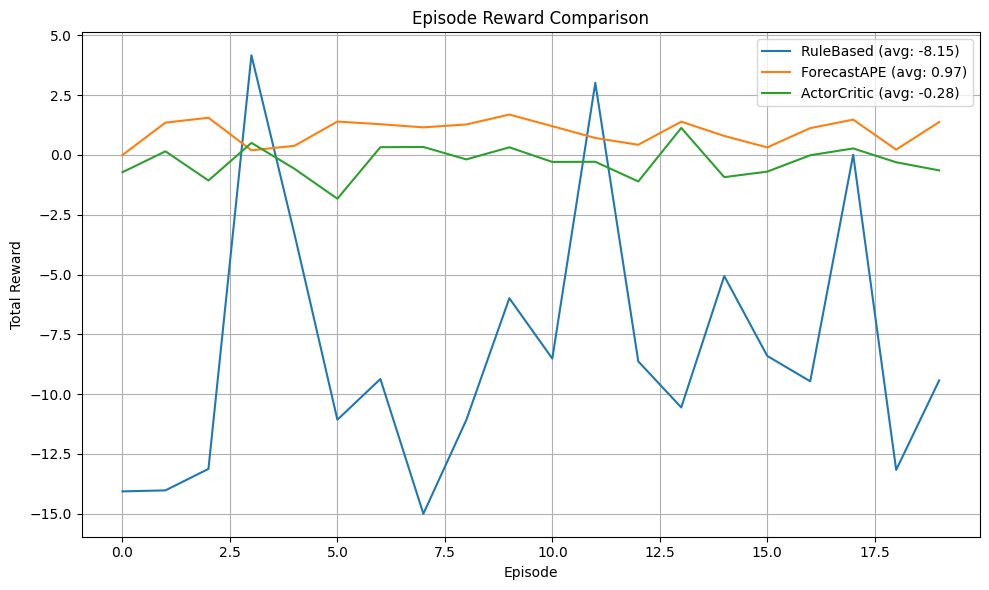

In [ ]:
evaluate_agents(env_config, episodes=20)


The RuleBasedAgent was added as a baseline for comparison:

Establish a Simple Human-Defined Baseline. Rule-based agents are easy to construct using domain knowledge.

 So when you see large negative episode rewards like it usually means:

The agent allowed overflow to occur early (ending the episode and applying a -1 penalty),

Multiple containers overflowed in rapid succession,

It wasted time with excessive "wait" actions,

Or it emptied containers far from their optimal volumes and received near-zero rewards repeatedly.



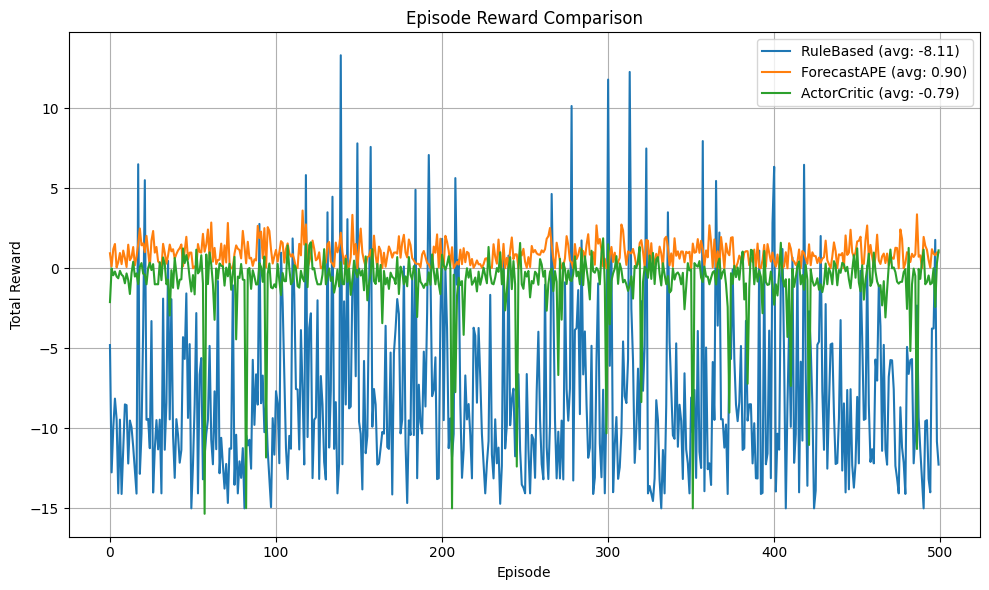

In [ ]:
evaluate_agents(env_config, episodes=500)

In [ ]:
# Forecast-Augmented Actor-Critic Training

class ForecastAugmentedActorCritic(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, n_actions),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        value = self.critic(x)
        probs = self.actor(x)
        return probs, value


def train_forecast_augmented(env_config, episodes=10, k=3, lambda_=0.2):
  # Extract container IDs and reward curve parameters
    container_ids = env_config.enabled_containers
    reward_params = {
        cid: {
            "peaks": env_config.containers[cid].reward.peaks,
            "heights": env_config.containers[cid].reward.heights,
            "widths": env_config.containers[cid].reward.widths
        }
        for cid in container_ids
    }
    # Map of maximum volumes for overflow risk calculation
    vmax_map = {cid: env_config.containers[cid].max_volume for cid in container_ids}
    # ForecastAPEAgent is used to compute forecasted priority scores
    forecast_agent = ForecastAPEAgent(container_ids, reward_params, vmax_map, lambda_=lambda_, k=k)
    # Initialize Actor-Critic model that uses both volume and forecasted priorities as input
    model = ForecastAugmentedActorCritic(input_dim=len(container_ids)*2, n_actions=len(container_ids)+1)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    gamma = 0.99

    rewards = []
    for ep in range(episodes):
        env = ContainerEnv(env_config)
        obs = env.reset()
        done = False
        total_reward = 0

        while not done:
           # Combine raw volume and forecasted priorities into augmented input
            volumes = dict(zip(env.container_ids, obs["volume"]))
            priorities = forecast_agent.get_priorities(volumes)
            input_vec = np.array([[volumes[cid], priorities[cid]] for cid in container_ids]).flatten()
            state = torch.tensor(input_vec, dtype=torch.float32).unsqueeze(0)
           # Forward pass through the actor and critic networks
            probs, value = model(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            action_idx = action.item()
           # Take action in the environment and observe next state and reward
            obs, reward, done, _ = env.step(action_idx)
           # Prepare next state input for value estimation
            volumes_next = dict(zip(env.container_ids, obs["volume"]))
            input_vec_next = np.array([[volumes_next[cid], priorities[cid]] for cid in container_ids]).flatten()
            next_state = torch.tensor(input_vec_next, dtype=torch.float32).unsqueeze(0)
           # Compute TD(0) advantage
            _, next_value = model(next_state)
            advantage = reward + gamma * next_value.item() - value.item()
           # Compute actor and critic losses
            actor_loss = -dist.log_prob(action) * advantage
            critic_loss = advantage ** 2
            loss = actor_loss + critic_loss
           # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_reward += reward
        rewards.append(total_reward)
        print(f"Episode {ep+1}: Reward = {total_reward}")
    return rewards


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Use previously defined evaluation methods for RuleBased and ForecastAPE
def evaluate_all_agents_with_augmented(env_config, episodes=20):
    from copy import deepcopy

    rewards = {
        "RuleBased": [],
        "ForecastAPE": [],
        "ActorCritic": [],
        "APE + ActorCritic": []
    }

    # Rule-Based Agent
    rule_agent = RuleBasedAgent(env_config)
    for _ in range(episodes):
        env = ContainerEnv(env_config)
        obs = env.reset()
        total = 0
        done = False
        while not done:
            action, _ = rule_agent.predict(obs)
            obs, reward, done, _ = env.step(action)
            total += reward
        rewards["RuleBased"].append(total)

    # Forecast APE Agent
    forecast_agent = ForecastAPEAgent(
        container_ids=env_config.enabled_containers,
        reward_params={cid: {
            "peaks": env_config.containers[cid].reward.peaks,
            "heights": env_config.containers[cid].reward.heights,
            "widths": env_config.containers[cid].reward.widths
        } for cid in env_config.enabled_containers},
        vmax_map={cid: env_config.containers[cid].max_volume for cid in env_config.enabled_containers}
    )
    for _ in range(episodes):
        env = ContainerEnv(env_config)
        obs = env.reset()
        total = 0
        done = False
        while not done:
            volumes = dict(zip(env.container_ids, obs["volume"]))
            priorities = forecast_agent.get_priorities(volumes)
            best_action = np.argmax([priorities[cid] for cid in env.container_ids])
            obs, reward, done, _ = env.step(best_action)
            total += reward
        rewards["ForecastAPE"].append(total)

    # ActorCritic (Vanilla)
    class ActorCriticWrapper:
        def __init__(self, env):
            self.env = env
            self.model = ActorCritic(input_dim=env.n_containers, n_actions=env.n_containers + 1)
            self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

        def train_one_episode(self):
            obs = self.env.reset()
            done = False
            total_reward = 0
            gamma = 0.99
            while not done:
                state = torch.tensor(obs['volume'], dtype=torch.float32).unsqueeze(0)
                probs, value = self.model(state)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                action_idx = action.item()
                next_obs, reward, done, _ = self.env.step(action_idx)
                next_state = torch.tensor(next_obs['volume'], dtype=torch.float32).unsqueeze(0)
                _, next_value = self.model(next_state)

                advantage = reward + gamma * next_value.item() - value.item()
                loss = -dist.log_prob(action) * advantage + advantage ** 2

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                obs = next_obs
                total_reward += reward
            return total_reward

    for _ in range(episodes):
        env = ContainerEnv(env_config)
        actor = ActorCriticWrapper(env)
        rewards["ActorCritic"].append(actor.train_one_episode())

    # APE + ActorCritic (Forecast-Augmented)
    augmented_rewards = train_forecast_augmented(deepcopy(env_config), episodes=episodes)
    rewards["APE + ActorCritic"] = augmented_rewards

    # Plotting
    plt.figure(figsize=(12, 6))
    for name, values in rewards.items():
        plt.plot(values, label=f"{name} (avg: {np.mean(values):.2f})")
    plt.title("Episode Reward Comparison Across Agents")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return rewards


Episode 1: Reward = -0.20999987364887554
Episode 2: Reward = -0.6612657033563933
Episode 3: Reward = -0.3007983687328524
Episode 4: Reward = -0.01999913022837187
Episode 5: Reward = -0.9999997668691272
Episode 6: Reward = -0.3469878291485866
Episode 7: Reward = -0.8620929322069574
Episode 8: Reward = -0.9999999999999326
Episode 9: Reward = 0.18411117056779505
Episode 10: Reward = -0.24466439564825093
Episode 11: Reward = -0.9697491310558894
Episode 12: Reward = -0.9999986187589036
Episode 13: Reward = -0.9999999999999999
Episode 14: Reward = -0.9792403334999304
Episode 15: Reward = -0.9999999999999857
Episode 16: Reward = -0.9999281936313152
Episode 17: Reward = -0.9999998282030251
Episode 18: Reward = -0.7532926877338033
Episode 19: Reward = -1.1099999999999999
Episode 20: Reward = 0.4775328600561961


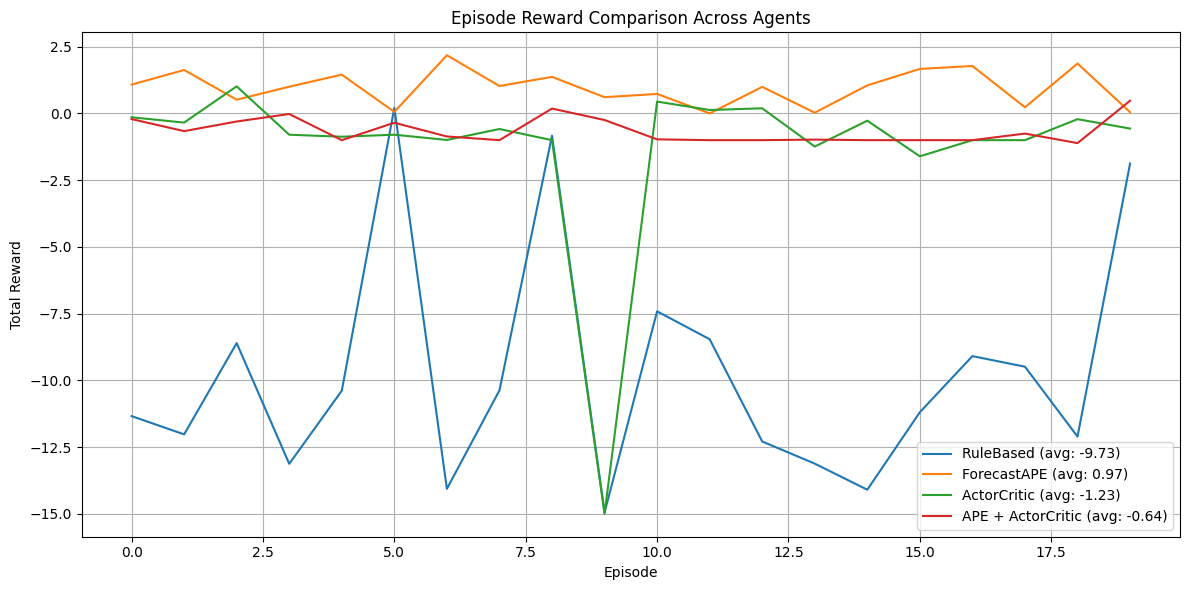

{'RuleBased': [np.float64(-11.339553718803675),
  np.float64(-12.024015759261477),
  np.float64(-8.604558865373846),
  np.float64(-13.127254112280797),
  np.float64(-10.387477406266434),
  np.float64(0.21207611772383927),
  np.float64(-14.064759846169277),
  np.float64(-10.375564572563222),
  np.float64(-0.829123909317668),
  np.float64(-14.951238534663936),
  np.float64(-7.4137798850666385),
  np.float64(-8.459183988237347),
  np.float64(-12.29047406309779),
  np.float64(-13.120224705288118),
  np.float64(-14.097960763906263),
  np.float64(-11.193095462009207),
  np.float64(-9.092195941508741),
  np.float64(-9.488626783750998),
  np.float64(-12.106129694405391),
  np.float64(-1.8760041736491675)],
 'ForecastAPE': [np.float64(1.0812872629081154),
  np.float64(1.6294575817356929),
  np.float64(0.5165091302993122),
  np.float64(1.0030337456628233),
  np.float64(1.4546135800186901),
  np.float64(0.0594745156279434),
  np.float64(2.1812807303878694),
  np.float64(1.0292052116465102),
  np.

In [ ]:
evaluate_all_agents_with_augmented(env_config, episodes=20)

Episode 1: Reward = -0.4769179216633164
Episode 2: Reward = -0.45895263041904155
Episode 3: Reward = -0.11903581351398418
Episode 4: Reward = -0.3331481633297082
Episode 5: Reward = -0.14626673315775685
Episode 6: Reward = -0.9999999999999739
Episode 7: Reward = -0.9804122482381162
Episode 8: Reward = 0.4165743881115418
Episode 9: Reward = -0.28195734701918274
Episode 10: Reward = -0.42242803933864004
Episode 11: Reward = -1.0
Episode 12: Reward = -0.5950190311749941
Episode 13: Reward = 0.020936428839570094
Episode 14: Reward = -0.8909978926375376
Episode 15: Reward = 0.01548694492174052
Episode 16: Reward = -0.06140034947670803
Episode 17: Reward = -1.1299999623768546
Episode 18: Reward = 0.7507548670487871
Episode 19: Reward = -0.9999999999999999
Episode 20: Reward = -0.3351935252115861
Episode 21: Reward = -0.13570635809708365
Episode 22: Reward = 0.21384270087640034
Episode 23: Reward = -0.38929002561936166
Episode 24: Reward = -0.9997033811041691
Episode 25: Reward = -0.406716397

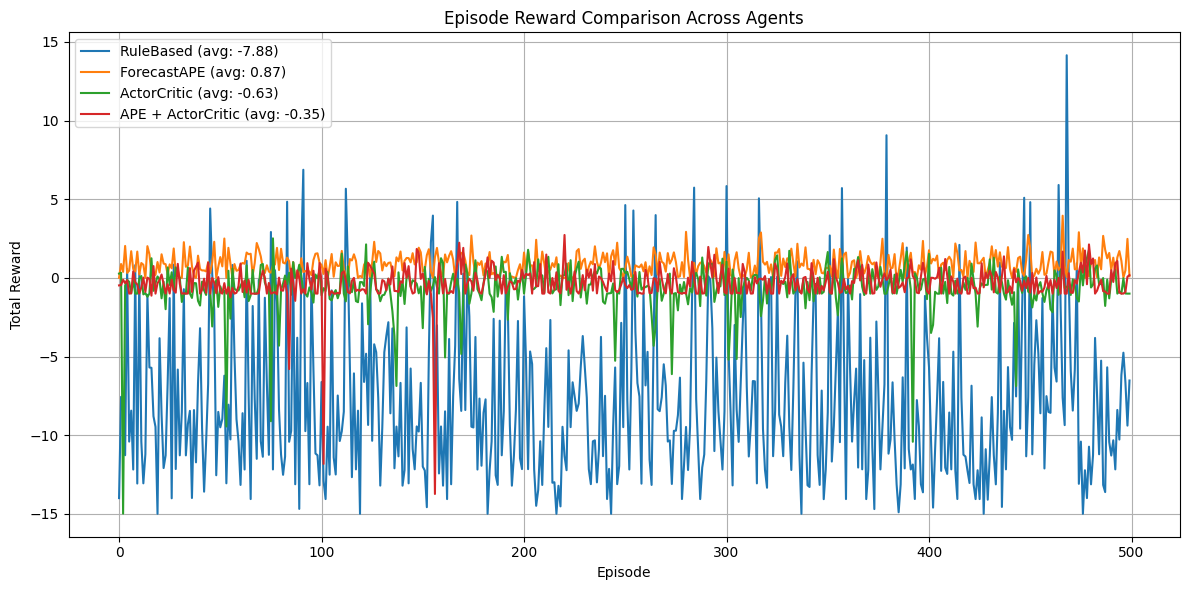

{'RuleBased': [np.float64(-14.001548641807807),
  np.float64(-7.561215948518238),
  np.float64(-8.475171173498671),
  np.float64(-11.275649123528469),
  np.float64(0.5669144496555902),
  np.float64(-10.409091258948456),
  np.float64(-8.441465292514561),
  np.float64(-12.184739002048463),
  np.float64(0.810976713527608),
  np.float64(-13.074324970257415),
  np.float64(0.3167062109302793),
  np.float64(-10.40568306145825),
  np.float64(-13.062928243124098),
  np.float64(-11.203989026714227),
  np.float64(-1.0750287219889496),
  np.float64(-5.694862568519624),
  np.float64(-5.717445224317411),
  np.float64(-8.797254071810132),
  np.float64(-9.471939077642737),
  -14.999999999999725,
  np.float64(-3.8357459041455084),
  np.float64(-8.67904651878532),
  np.float64(-12.090879260859799),
  np.float64(-11.28254445403756),
  np.float64(-6.711041835854057),
  np.float64(-1.2856686341824763),
  np.float64(-14.015456799919567),
  np.float64(0.8405126978692492),
  np.float64(-12.15264479234419),
  

In [ ]:
evaluate_all_agents_with_augmented(env_config, episodes=500)

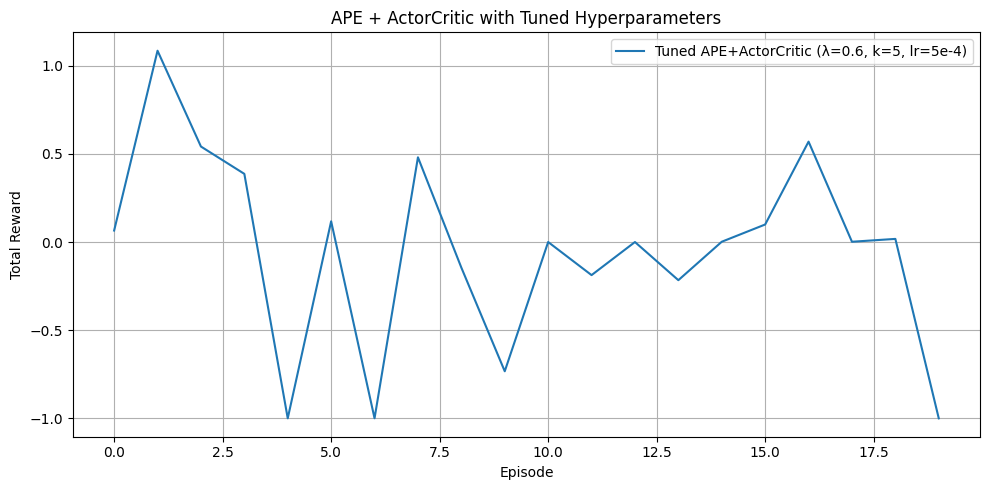

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# ForecastAPEAgent with Kalman filters

import numpy as np
import torch
import torch.nn as nn
from scipy.stats import norm

class KalmanFilter:
    def __init__(self, initial_volume, initial_rate=0.0, Q=None, R=None):
        self.x = np.array([[initial_volume], [initial_rate]])  # state: [volume, fill_rate]
        self.P = np.eye(2)
        self.A = np.array([[1, 1], [0, 1]])
        self.H = np.array([[1, 0]])
        self.Q = Q if Q is not None else np.diag([1e-2, 1e-4])
        self.R = R if R is not None else np.array([[1e-2]])

    def predict(self):
        self.x = self.A @ self.x
        self.P = self.A @ self.P @ self.A.T + self.Q
        return self.x.flatten()

    def update(self, z):
        y = np.array([[z]]) - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(2) - K @ self.H) @ self.P

class ForecastAPEAgent:
    def __init__(self, container_ids, reward_params, vmax_map, lambda_=0.6, k=5):
        self.filters = {cid: KalmanFilter(initial_volume=0.0) for cid in container_ids}
        self.reward_params = reward_params
        self.vmax_map = vmax_map
        self.lambda_ = lambda_
        self.k = k

    def compute_priority(self, cid):
        v_hat, alpha_hat = self.filters[cid].predict()
        v_future = v_hat + self.k * alpha_hat

        peaks = self.reward_params[cid]["peaks"]
        widths = self.reward_params[cid]["widths"]
        heights = self.reward_params[cid]["heights"]

        prox = max([
            h * np.exp(-((v_future - peak) ** 2) / (2 * w ** 2))
            for peak, w, h in zip(peaks, widths, heights)
        ])

        vmax = self.vmax_map[cid]
        rho = 1 - norm.cdf(vmax, loc=v_future, scale=np.sqrt(self.filters[cid].P[0, 0]))
        return prox - self.lambda_ * rho

    def update_filter(self, cid, observed_volume):
        self.filters[cid].update(observed_volume)

    def get_priorities(self, observation_dict):
        priorities = {}
        for cid, obs in observation_dict.items():
            self.update_filter(cid, obs)
            priorities[cid] = self.compute_priority(cid)
        return priorities

    def get_normalized_priorities(self, observation_dict):
      """
    Compute normalized priority scores for each container based on forecasted metrics.
    This function is particularly useful when using forecasted priorities as input
    features to a learning algorithm (e.g., actor-critic), ensuring that the scale
    of priorities is consistent across containers and time steps.

    Parameters:
    -----------
    observation_dict : dict
        A dictionary mapping container IDs to their current observed volume.

    Returns:
    --------
    normed_priorities : dict
        A dictionary mapping container IDs to their normalized priority scores.
        The scores have zero mean and unit variance across the container set.

    raw : np.ndarray
        The array of unnormalized raw priority scores (for analysis or debugging).
    """
        raw = [] # List to hold raw priority values
        priorities = {} # Dictionary to store priority per container
        # Compute raw priorities for each container using forecasted volumes
        for cid, obs in observation_dict.items():
            self.update_filter(cid, obs) # Update Kalman filter with latest observation
            p = self.compute_priority(cid) # Compute priority using APE rule
            priorities[cid] = p # Store raw priority
            raw.append(p) # Add to list for normalization
        # Normalize priority scores using z-score normalization
        raw = np.array(raw)
        normed = (raw - np.mean(raw)) / (np.std(raw) + 1e-8) # Add epsilon to avoid divide-by-zero
        # Return normalized priorities as a dictionary
        return {cid: normed[i] for i, cid in enumerate(observation_dict)}, raw

# Actor-Critic Model
class ActorCritic(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, n_actions), nn.Softmax(dim=-1))
        self.critic = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(), nn.Linear(64, 1))

    def forward(self, x):
        return self.actor(x), self.critic(x)

# APE + ActorCritic Combined Training
def train_ape_actor_critic(env_config, episodes=20):
    env = ContainerEnv(env_config)
    forecast_agent = ForecastAPEAgent(
        container_ids=env_config.enabled_containers,
        reward_params={cid: {
            "peaks": env_config.containers[cid].reward.peaks,
            "heights": env_config.containers[cid].reward.heights,
            "widths": env_config.containers[cid].reward.widths
        } for cid in env_config.enabled_containers},
        vmax_map={cid: env_config.containers[cid].max_volume for cid in env_config.enabled_containers}
    )

    model = ActorCritic(input_dim=2 * env.n_containers, n_actions=env.n_containers + 1)
    optimizer = optim.Adam(model.parameters(), lr=5e-4)
    gamma = 0.99
    episode_rewards = []

    for ep in range(episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            obs_dict = dict(zip(env.container_ids, obs["volume"]))
            normed_priorities, _ = forecast_agent.get_normalized_priorities(obs_dict)
            input_vec = np.array([
                [obs["volume"][i], normed_priorities[env.container_ids[i]]]
                for i in range(env.n_containers)
            ]).flatten()

            state = torch.tensor(input_vec, dtype=torch.float32).unsqueeze(0)
            probs, value = model(state)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            action_idx = action.item()

            next_obs, reward, done, _ = env.step(action_idx)
            next_obs_dict = dict(zip(env.container_ids, next_obs["volume"]))
            next_normed_priorities, _ = forecast_agent.get_normalized_priorities(next_obs_dict)
            next_input_vec = np.array([
                [next_obs["volume"][i], next_normed_priorities[env.container_ids[i]]]
                for i in range(env.n_containers)
            ]).flatten()

            next_state = torch.tensor(next_input_vec, dtype=torch.float32).unsqueeze(0)
            _, next_value = model(next_state)

            advantage = reward + gamma * next_value.item() - value.item()
            actor_loss = -dist.log_prob(action) * advantage
            critic_loss = advantage ** 2

            loss = actor_loss + critic_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            obs = next_obs
            total_reward += reward

        episode_rewards.append(total_reward)
    return episode_rewards

# Run and plot
rewards = train_ape_actor_critic(env_config, episodes=20)

# Plotting the rewards
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="Tuned APE+ActorCritic (λ=0.6, k=5, lr=5e-4)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("APE + ActorCritic with Tuned Hyperparameters")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
